In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Solenoid ##

In class we derived the equations for the vector potential and magnetic field for a solenoid in terms of elliptic functions.  Since these functions are so standard, most mathematical libraries (including ```mpmath``` but weirdly not ```scipy.special```) provide routines for computing them.  This makes it very easy to plot the field lines for a solenoid ...

To recap, the solenoid has its axis along $\hat{z}$ and runs from $-L/2$ to $L/2$.  All of the current runs in the $\hat{e}_\theta$ direction in an infinitely thin region a distance $a$ from the $z$-axis.


In terms of elliptic functions
$$
  B_R = \frac{2\mu I}{Lc}\sqrt{\frac{a}{R}}
  \left.\left[\frac{k^2-2}{k}K(k^2)+\frac{2}{k}E(k^2)\right]\right|^{\zeta_{+}}_{\zeta_{-}}
$$
and
$$
  B_z = \frac{\mu I}{c}\frac{1}{L\sqrt{aR}}
  \left.\left[\zeta k\left(K(k^2)+\frac{a-R}{a+R}\Pi(h^2,k^2)\right)\right]\right|^{\zeta_{+}}_{\zeta_{-}}
$$
where
$$
  \zeta_{\pm} = z\pm\frac{L}{2} \quad , \quad
  k^2 = \frac{4aR}{(R+a)^2+\zeta^2} \quad , \quad
  h^2 = \frac{4aR}{(R+a)^2}
$$

In [2]:
# Set up the constants for our problem.
L,a = 2.0,1.0

In [3]:
# We'll use the (complete) elliptic integrals from mpmath.
# This is a pretty standard package, highly useful for doing
# arbitrary precision arithmetic as well as having a wide
# variety of special functions and other useful things ... but
# it is not always installed.  If you don't have it, you can
# use pip install mpmath.  Or use conda, or whatever package
# manager you prefer.
import mpmath as mp
from mpmath import ellipk,ellipe,ellippi,mpf

In [4]:
# Set up our plot region:
Rmin,Rmax = 1e-3,2.0
Zmin,Zmax = 0.00,1.5
Nx,Ny     = 32,16
B_z,B_R   = np.zeros((Nx,Ny)),np.zeros((Nx,Ny))

In [5]:
# It's a little tricky to use mpmath functions on 2D arrays,
# so let's just loop.  Awkward, but it gets the job done...
#
# This takes a little while to run ...
#
for ix,R in enumerate(np.linspace(Rmin,Rmax,Nx)):
    for iy,Z in enumerate(np.linspace(Zmin,Zmax,Ny)):
        zp = mpf(Z + L/2)
        zm = mpf(Z - L/2)
        h2 = mpf(4*a*R/(R+a)**2 )
        k2p= mpf(4*a*R/((R+a)**2+zp**2))
        kp = mp.sqrt(k2p)
        k2m= mpf(4*a*R/((R+a)**2+zm**2))
        km = mp.sqrt(k2m)
        aRaR=mpf((a-R)/(a+R))
        #
        B_R[ix,iy] = 2/L*np.sqrt(a/R)*( ((k2p-2)/kp*ellipk(k2p)+2/kp*ellipe(k2p)) -\
                                        ((k2m-2)/km*ellipk(k2m)+2/km*ellipe(k2m))  ) 
        B_z[ix,iy] = 1/L/np.sqrt(a*R)*( (zp*kp)*(ellipk(k2p)+aRaR*ellippi(h2,k2p))-\
                                        (zm*km)*(ellipk(k2m)+aRaR*ellippi(h2,k2m)) )
Bval   = np.sqrt( B_R**2 + B_z**2 )
print("B field in range [{:12.4e},{:12.4e}]".format(np.min(Bval),np.max(Bval)))

B field in range [  2.9308e-01,  5.1242e+00]


Now we can plot $\vec{B}$ in the $\theta=0$ plane.  We only need to worry about $z>0$, when it comes to plotting we could always mirror things around to cover the full range.

Text(0, 0.5, '$z$')

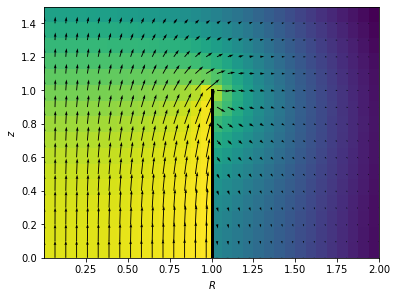

In [6]:
# Let's plot this as a vector field.
X,Y = np.meshgrid(np.linspace(Rmin,Rmax,Nx),np.linspace(Zmin,Zmax,Ny),indexing='ij')
#
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(np.log(5*Bval.T),origin='lower',extent=[Rmin,Rmax,Zmin,Zmax])
ax.quiver(X,Y,B_R,B_z)
ax.plot([a,a],[0,L/2.],'k-',lw=3)  # The solenoid.
ax.set_xlabel('$R$')
ax.set_ylabel('$z$')

### Ampere's law ###

Of course, there is another (more mundane) way to get the field lines for a solenoid.  We could just integrate "Ampere's law" given a current!  We have to do a 2D integral for each observation point, so this is a bit annoying, but it's relatively quick to code.

To recap, the solenoid has its axis along $\hat{z}$ and runs from $-L/2$ to $L/2$.  All of the current runs in the $\hat{e}_\theta$ direction in an infinitely thin region a distance $a$ from the $z$-axis.

Given the symmetry we want to use cylindrical coordinates, $(R,\theta,z)$, and we can work at $\theta=0$.  Recall
$$
  \vec{B}(R_1,\theta_1=0,z_1) = \frac{\mu I a}{c}\int_{-L/2}^{L/2}dz_2\int_0^{2\pi}d\theta_2
  \frac{\hat{e}_{\theta_2}\times\vec{r}_{12}}{r_{12}^3}
$$
where $I$ is a current density and $\vec{r}_{12}=\vec{r}_1-\vec{r}_2$.  In our case the Cartesian components of $\vec{r}_i$ are
$$
  \vec{r}_1=\left[ R_1 , 0 , z_1 \right] \quad , \quad
  \vec{r}_2=\left[ a\cos\theta_2 , a\sin\theta_2, z_2 \right]
$$
so
$$
  r_{12}^3 = \left[ R_1^2+a^2\cos^2\theta_2-2aR_1\cos\theta_2 + (z_1-z_2)^2 \right]^{3/2}
$$
We'll drop the prefactor (or work in units of $\mu Ia/c$) and concentrate on the integral.  Only two components of $\vec{B}$ are non-zero: $B_z$ and $B_R$.  Using $\hat{v}\cdot(\hat{e}_{\theta}\times\vec{r})=\vec{r}\cdot(\hat{v}\times\hat{e}_{\theta})$ we have
$$
  \hat{e}_{z_1}\cdot(\hat{e}_{\theta_2}\times\vec{r}) =
  \hat{e}_{z_2}\cdot(\hat{e}_{\theta_2}\times\vec{r}) =
  -\hat{e}_{R_2}\cdot\vec{r}
$$
For $B_R$ it is a bit more complicated because we want the $\hat{e}_{R_1}$ not the $\hat{e}_{R_2}$ component and they're not easily related.  Recall $\hat{e}_{\theta}=(-\sin\theta,\cos\theta,0)$ and we want the 1st component which has only one non-zero piece: $\cos\theta_2 r_{12}^{z}$.

We'll use ```scipy.integrate.dblquad``` because it's easily available.  If we were doing this in some critical setting we'd probably tailor the integrator to the problem.

In [7]:
from scipy.integrate import dblquad

def dB_z(theta2,z2,R1,z1):
    """The integrand for B_z ... note the order of the arguments, following
    the dblquad convention of y before x.  We are integrating in z2 and theta2.
    The values of R1 and z1 are 'args'."""
    r1 = np.array([R1,0,z1])
    r2 = np.array([a*np.cos(theta2),a*np.sin(theta2),z2])
    eR2= np.array([np.cos(theta2),np.sin(theta2),0.0])
    r12= r1 - r2
    num= -np.dot(eR2,r12)
    den= (np.sum(r12**2))**(3./2.) + 1e-20
    return(num/den)
    #

def dB_R(theta2,z2,R1,z1):
    """The integrand for B_R ... note the order of the arguments, following
    the dblquad convention of y before x.  We are integrating in z2 and theta2.
    The values of R1 and z1 are 'args'."""
    r1 = np.array([R1,0,z1])
    r2 = np.array([a*np.cos(theta2),a*np.sin(theta2),z2])
    r12= r1 - r2
    num= np.cos(theta2)*r12[2]
    den= (np.sum(r12**2))**(3./2.) + 1e-20
    return(num/den)
    #

# Just check the code doesn't crash or produce infinities... we'll evaluate
# the two components at R1=z1=0:
dblquad(dB_z,-L/2.,L/2.,0.,2*np.pi,(0.0,0.0)),\
dblquad(dB_R,-L/2.,L/2.,0.,2*np.pi,(0.0,0.0))

((8.885765876316732, 9.865181867818617e-14), (0.0, 1.7193579279039164e-14))

Now we can plot $\vec{B}$ in the $\theta_1=0$ plane.  Let's start by computing the two components on a regular grid.  We only need to worry about $z_1>0$, when it comes to plotting we could always mirror things around to cover the full range.

In [8]:
# Set up our plot region:
Rmin,Rmax = 0.0,2.0
Zmin,Zmax = 0.0,3.0
Nx,Ny     = 16,8
B_z,B_R   = np.zeros((Nx,Ny)),np.zeros((Nx,Ny))
#
# This isn't the most Pythonic way of doing this, but I think
# it might be the clearest.  We want just the value of the
# integral, we'll throw away the error estimate.
#
# This is pretty slow!
#
for ix,R1 in enumerate(np.linspace(Rmin,Rmax,Nx)):
    for iy,z1 in enumerate(np.linspace(Zmin,Zmax,Ny)):
        B_R[ix,iy] = dblquad(dB_R,-L/2.,L/2.,0.,2*np.pi,(R1,z1))[0]
        B_z[ix,iy] = dblquad(dB_z,-L/2.,L/2.,0.,2*np.pi,(R1,z1))[0]
Bval   = np.sqrt( B_R**2 + B_z**2 )
print("B field in range [{:12.4e},{:12.4e}]".format(np.min(Bval),np.max(Bval)))

B field in range [  2.3981e-01,  1.0168e+01]


Text(0, 0.5, '$z$')

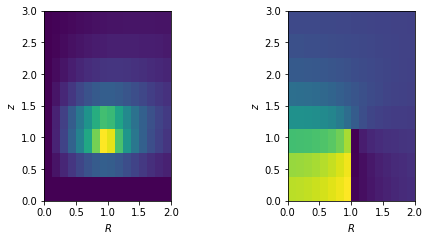

In [9]:
# Let's just plot the components to check for sanity!
fig,ax = plt.subplots(1,2,figsize=(8,3.5))
ax[0].imshow(B_R.T,origin='lower',extent=[Rmin,Rmax,Zmin,Zmax])
ax[1].imshow(B_z.T,origin='lower',extent=[Rmin,Rmax,Zmin,Zmax])
ax[0].set_xlabel('$R$')
ax[1].set_xlabel('$R$')
ax[0].set_ylabel('$z$')
ax[1].set_ylabel('$z$')

Text(0, 0.5, '$z$')

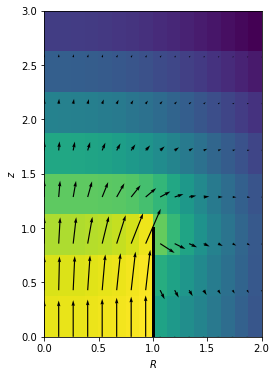

In [10]:
# Let's plot this as a vector field.
X,Y = np.meshgrid(np.linspace(Rmin,Rmax,Nx),np.linspace(Zmin,Zmax,Ny),indexing='ij')
#
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(np.log(5*Bval.T),origin='lower',extent=[Rmin,Rmax,Zmin,Zmax])
ax.quiver(X,Y,B_R,B_z)
ax.plot([a,a],[0,L/2.],'k-',lw=3)  # The solenoid.
ax.set_xlabel('$R$')
ax.set_ylabel('$z$')

With a little bit of work you can "reflect" this vector field so that we have $x<0$ as well as $x\ge 0$ and $z<0$ as well as $z\ge 0$.  This gives the more familiar picture.  You can also draw in the solenoid (just a black line above) with caps at the ends etc.